### Q1.

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler.
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

In [46]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [47]:
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C, G = 3, 10000  # Chains, Gibbs samples
theta, tau = np.zeros([C, G]), np.zeros([C, G])
theta[:, 0] = 100  # Initialization

for c in range(C):
    for g in range(1, G):
        tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c, g-1], scale=(1/tau_)**0.5).pdf(x)) * stats.expon(scale=1).pdf(tau_)
        tau_proposal = stats.expon(scale=2)
        tau_tilde = tau_proposal.rvs()
        mh_tau = (tau_target(tau_tilde) / tau_target(tau[c, g-1])) * (tau_proposal.pdf(tau[c, g-1]) / tau_proposal.pdf(tau_tilde))
        acceptance_probability = min(1, mh_tau)
        tau[c, g] = tau_tilde if stats.uniform().rvs() < acceptance_probability else tau[c, g-1]

        theta_target = lambda theta_: np.prod(stats.norm(loc=theta_, scale=(1/tau[c, g])**0.5).pdf(x)) * stats.norm(loc=0, scale=10).pdf(theta_)
        theta_proposal = stats.norm(loc=theta[c, g-1], scale=1)
        theta_tilde = theta_proposal.rvs()
        mh_theta = (theta_target(theta_tilde) / theta_target(theta[c, g-1])) * (theta_proposal.pdf(theta[c, g-1]) / theta_proposal.pdf(theta_tilde))
        acceptance_probability_theta = min(1, mh_theta)
        theta[c, g] = theta_tilde if stats.uniform().rvs() < acceptance_probability_theta else theta[c, g-1]

<ipython-input-47-d7894491c420>:8: RuntimeWarning: divide by zero encountered in scalar divide
  tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c, g-1], scale=(1/tau_)**0.5).pdf(x)) * stats.expon(scale=1).pdf(tau_)
<ipython-input-47-d7894491c420>:11: RuntimeWarning: invalid value encountered in scalar divide
  mh_tau = (tau_target(tau_tilde) / tau_target(tau[c, g-1])) * (tau_proposal.pdf(tau[c, g-1]) / tau_proposal.pdf(tau_tilde))
<ipython-input-47-d7894491c420>:18: RuntimeWarning: invalid value encountered in scalar divide
  mh_theta = (theta_target(theta_tilde) / theta_target(theta[c, g-1])) * (theta_proposal.pdf(theta[c, g-1]) / theta_proposal.pdf(theta_tilde))
<ipython-input-47-d7894491c420>:11: RuntimeWarning: divide by zero encountered in scalar divide
  mh_tau = (tau_target(tau_tilde) / tau_target(tau[c, g-1])) * (tau_proposal.pdf(tau[c, g-1]) / tau_proposal.pdf(tau_tilde))


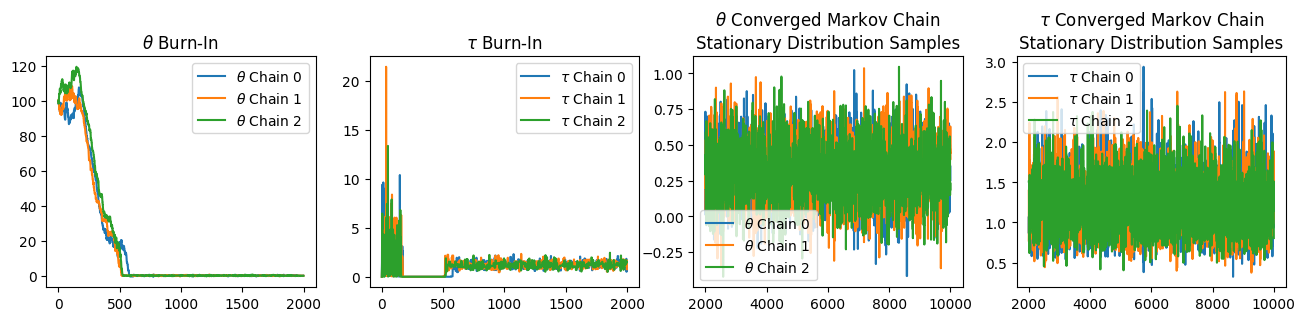

In [48]:
fig,ax = plt.subplots(1, 4, figsize=(16,3));
ax[0].set_title("$\\theta$ Burn-In");
ax[1].set_title("$\\tau$ Burn-In");
ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples");
ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 2000
demo = 10000
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();

**Model Specifications:**
\begin{align*}
  \text{Data Generating Process} : x_i &\sim \mathcal{N}\left( \theta, \tau = \frac{1}{\sigma^2} \right)\\
  \text{Prior Distributions} : \theta &\sim \mathcal{N}(0, 10^2)\\
  \tau &\sim \text{Exp}(1)
\end{align*}

**$\tau$ Sampling:**
<br>We can define the full conditional like such:
\begin{align*}
  p(\tau|\theta, x) &\propto \left[ \prod^{n}_{i=1} \mathcal{N} \left( x_i|\theta, \frac{1}{\sqrt{\tau}} \right) \right] \cdot \text{Exp}(\tau|1)\\
  &\propto \text{???}
\end{align*}
It was not derived fully but after looking at the corresponding functions as well as scholarly sources, derivation of a closed form solution for this full conditional seems unlikely. Thus, we employ Metropolis-Hastings:
\begin{align*}
    \text{Proposal} : \tilde{\tau} &\sim \text{Exp}(2)\\
  \text{Acceptance} : \alpha &= \min{\left( 1, \frac{p(\tilde{\tau}|\theta, x)}{p(\tau^{(t - 1)}|\theta, x)} \cdot \frac{q(\tau^{(t - 1)}|\tilde{\tau})}{q(\tilde{\tau}|\tau^{(t - 1)})} \right)}
\end{align*}

**$\theta$ Sampling:**
<br>We can define the full conditional like such:
\begin{align*}
  p(\theta|\tau, x) &\propto \left[ \prod^{n}_{i=1} \mathcal{N} \left( x_i|\theta, \frac{1}{\sqrt{\tau}} \right) \right] \cdot \mathcal{N}(\theta|0, 10^2)\\
  &\propto \text{???}
\end{align*}
Maybe there is a closed form solution for this full conditional, maybe not. It doesn't really matter because, like we did with $\tau$, we will be implementing MH on $\theta$ for Gibbs sampling:
\begin{align*}
    \text{Proposal} : \tilde{\theta} &\sim \mathcal{N}(\theta^{(t - 1)}, 1^2)\\
  \text{Acceptance} : \alpha &= \min{\left( 1, \frac{p(\tilde{\theta}|\tau, x)}{p(\theta^{(t - 1)}|\tau, x)} \cdot \frac{q(\theta^{(t - 1)}|\tilde{\theta})}{q(\tilde{\theta}|\theta^{(t - 1)})} \right)}\\
  &= \min{\left( 1, \frac{p(\tilde{\theta}|\tau, x)}{p(\theta^{(t - 1)}|\tau, x)} \right)} \tag*{since symmetric proposal}
\end{align*}

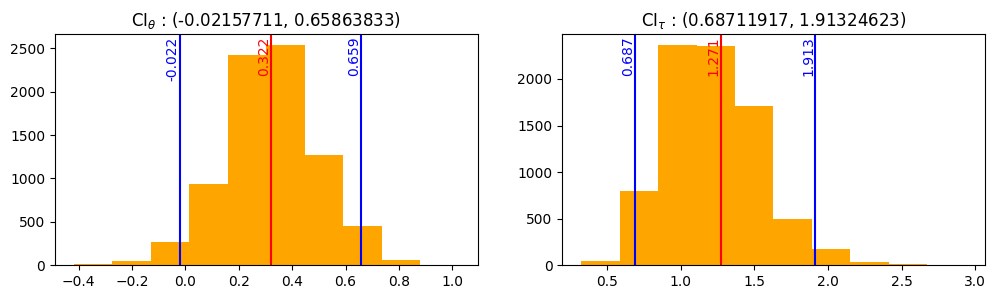

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(12,3));
ci1 = np.quantile(theta[0, burn:], 0.025).round(8), np.quantile(theta[0, burn:], 0.975).round(8)
ci2 = np.quantile(tau[0, burn:], 0.025).round(8), np.quantile(tau[0, burn:], 0.975).round(8)
ax[0].set_title("$\\text{CI}_{\\theta}$ : " + str(ci1));
ax[1].set_title("$\\text{CI}_{\\tau}$ : " + str(ci2));

ax[0].hist(theta[0, burn:], color='orange')
ax[0].axvline(x.mean(), color='r')
ax[0].axvline(np.quantile(theta[0, burn:], 0.025), color='b')
ax[0].axvline(np.quantile(theta[0, burn:], 0.975), color='b')
ax[0].text(np.quantile(theta[0, burn:], 0.025), 0.99, np.quantile(theta[0, burn:], 0.025).round(3),
           color='b', ha='right', va='top', rotation=90, transform=ax[0].get_xaxis_transform())
ax[0].text(x.mean(), 0.99, x.mean().round(3),
           color='r', ha='right', va='top', rotation=90, transform=ax[0].get_xaxis_transform())
ax[0].text(np.quantile(theta[0, burn:], 0.975), 0.99, np.quantile(theta[0, burn:], 0.975).round(3),
           color='b', ha='right', va='top', rotation=90, transform=ax[0].get_xaxis_transform())

ax[1].hist(tau[0, burn:], color='orange')
ax[1].axvline(1/x.var(), color='r')
ax[1].axvline(np.quantile(tau[0, burn:], 0.025), color='b')
ax[1].axvline(np.quantile(tau[0, burn:], 0.975), color='b')
ax[1].text(np.quantile(tau[0, burn:], 0.025), 0.99, np.quantile(tau[0, burn:], 0.025).round(3),
           color='b', ha='right', va='top', rotation=90, transform=ax[1].get_xaxis_transform())
ax[1].text(1/x.var(), 0.99, (1/x.var()).round(3),
           color='r', ha='right', va='top', rotation=90, transform=ax[1].get_xaxis_transform())
ax[1].text(np.quantile(tau[0, burn:], 0.975), 0.99, np.quantile(tau[0, burn:], 0.975).round(3),
           color='b', ha='right', va='top', rotation=90, transform=ax[1].get_xaxis_transform())

ci1 = np.quantile(theta[0, burn:], 0.025), np.quantile(theta[0, burn:], 0.975)
ci2 = np.quantile(tau[0, burn:], 0.025), np.quantile(tau[0, burn:], 0.975)

**Bayesian inference provided by this sampler and comparison to the Gibbs sampling model from last week:**

The full conditionals for $\tau$ and $\theta$ cannot be ascertained to be standard known distributions (mostly for impracticality than impossibility, the latter aspect of which is explored in Q2), thus we use Metropolis-Hastings updates rather than sampling directly using Gibbs.

The 95% credible intervals show that after the burn-in period, our predictions for both $\theta$ and $\tau$ remained consistent and around their true values from the original DGP.

In the end, convergence was achieved in our instance, but the model could nevertheless have diverged if our arbitrary proposals as well as their hyperparameters were poorly chosen.

### Q2.

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.Inf, loc=tau_t_minus_1, scale=s)
```
- Use a prior for $\theta$ that is not a normal distribution

*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof)  of analytically determining the full conditional distributions when using Metropolis-Hastings.*

In [59]:
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C, G = 3, 10000  # Chains, Gibbs samples
theta, tau = np.zeros([C, G]), np.zeros([C, G])
theta[:, 0] = 10  # Initialization

for c in range(C):
    for g in range(1, G):
        tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c, g-1], scale=(1/tau_)**0.5).pdf(x)) * stats.expon(scale=1).pdf(tau_)
        tau_proposal = stats.truncnorm(a=-tau[c, g-1]/2, b=np.inf, loc=tau[c, g-1], scale=2)
        tau_tilde = tau_proposal.rvs()
        mh_tau = (tau_target(tau_tilde) / tau_target(tau[c, g-1])) * (tau_proposal.pdf(tau[c, g-1]) / tau_proposal.pdf(tau_tilde))
        acceptance_probability = min(1, mh_tau)
        tau[c, g] = tau_tilde if stats.uniform().rvs() < acceptance_probability else tau[c, g-1]

        theta_target = lambda theta_: np.prod(stats.norm(loc=theta_, scale=(1/tau[c, g])**0.5).pdf(x)) * stats.laplace(loc=0, scale=10).pdf(theta_)
        theta_proposal = stats.norm(loc=theta[c, g-1], scale=1)
        theta_tilde = theta_proposal.rvs()
        mh_theta = (theta_target(theta_tilde) / theta_target(theta[c, g-1])) * (theta_proposal.pdf(theta[c, g-1]) / theta_proposal.pdf(theta_tilde))
        acceptance_probability_theta = min(1, mh_theta)
        theta[c, g] = theta_tilde if stats.uniform().rvs() < acceptance_probability_theta else theta[c, g-1]

<ipython-input-59-cc95b6fab7b3>:8: RuntimeWarning: divide by zero encountered in scalar divide
  tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c, g-1], scale=(1/tau_)**0.5).pdf(x)) * stats.expon(scale=1).pdf(tau_)
<ipython-input-59-cc95b6fab7b3>:11: RuntimeWarning: invalid value encountered in scalar divide
  mh_tau = (tau_target(tau_tilde) / tau_target(tau[c, g-1])) * (tau_proposal.pdf(tau[c, g-1]) / tau_proposal.pdf(tau_tilde))
<ipython-input-59-cc95b6fab7b3>:18: RuntimeWarning: invalid value encountered in scalar divide
  mh_theta = (theta_target(theta_tilde) / theta_target(theta[c, g-1])) * (theta_proposal.pdf(theta[c, g-1]) / theta_proposal.pdf(theta_tilde))
<ipython-input-59-cc95b6fab7b3>:11: RuntimeWarning: divide by zero encountered in scalar divide
  mh_tau = (tau_target(tau_tilde) / tau_target(tau[c, g-1])) * (tau_proposal.pdf(tau[c, g-1]) / tau_proposal.pdf(tau_tilde))


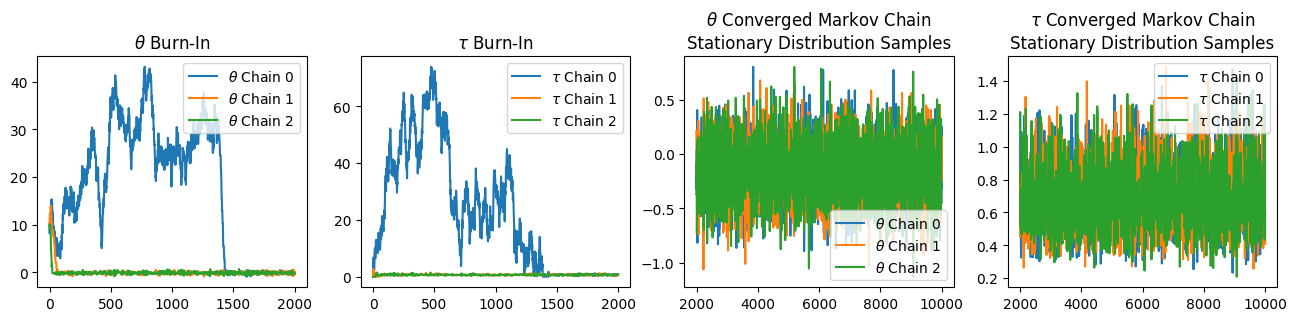

In [64]:
fig,ax = plt.subplots(1, 4, figsize=(16,3));
ax[0].set_title("$\\theta$ Burn-In");
ax[1].set_title("$\\tau$ Burn-In");
ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples");
ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 2000
demo = 10000
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();

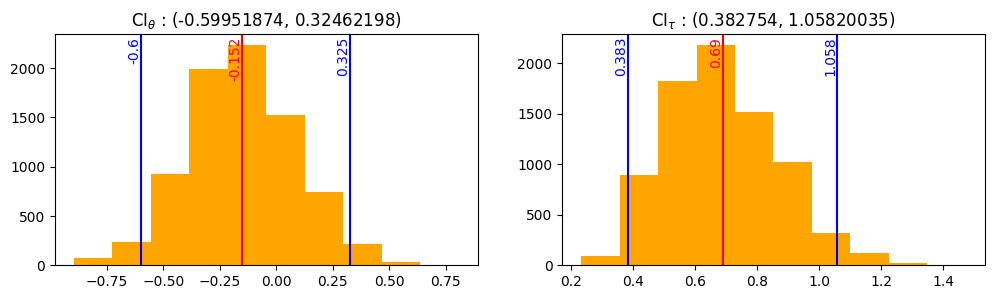

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(12,3));
ci1 = np.quantile(theta[0, burn:], 0.025).round(8), np.quantile(theta[0, burn:], 0.975).round(8)
ci2 = np.quantile(tau[0, burn:], 0.025).round(8), np.quantile(tau[0, burn:], 0.975).round(8)
ax[0].set_title("$\\text{CI}_{\\theta}$ : " + str(ci1));
ax[1].set_title("$\\text{CI}_{\\tau}$ : " + str(ci2));

ax[0].hist(theta[0, burn:], color='orange')
ax[0].axvline(x.mean(), color='r')
ax[0].axvline(np.quantile(theta[0, burn:], 0.025), color='b')
ax[0].axvline(np.quantile(theta[0, burn:], 0.975), color='b')
ax[0].text(np.quantile(theta[0, burn:], 0.025), 0.99, np.quantile(theta[0, burn:], 0.025).round(3),
           color='b', ha='right', va='top', rotation=90, transform=ax[0].get_xaxis_transform())
ax[0].text(x.mean(), 0.99, x.mean().round(3),
           color='r', ha='right', va='top', rotation=90, transform=ax[0].get_xaxis_transform())
ax[0].text(np.quantile(theta[0, burn:], 0.975), 0.99, np.quantile(theta[0, burn:], 0.975).round(3),
           color='b', ha='right', va='top', rotation=90, transform=ax[0].get_xaxis_transform())

ax[1].hist(tau[0, burn:], color='orange')
ax[1].axvline(1/x.var(), color='r')
ax[1].axvline(np.quantile(tau[0, burn:], 0.025), color='b')
ax[1].axvline(np.quantile(tau[0, burn:], 0.975), color='b')
ax[1].text(np.quantile(tau[0, burn:], 0.025), 0.99, np.quantile(tau[0, burn:], 0.025).round(3),
           color='b', ha='right', va='top', rotation=90, transform=ax[1].get_xaxis_transform())
ax[1].text(1/x.var(), 0.99, (1/x.var()).round(3),
           color='r', ha='right', va='top', rotation=90, transform=ax[1].get_xaxis_transform())
ax[1].text(np.quantile(tau[0, burn:], 0.975), 0.99, np.quantile(tau[0, burn:], 0.975).round(3),
           color='b', ha='right', va='top', rotation=90, transform=ax[1].get_xaxis_transform())

ci1 = np.quantile(theta[0, burn:], 0.025), np.quantile(theta[0, burn:], 0.975)
ci2 = np.quantile(tau[0, burn:], 0.025), np.quantile(tau[0, burn:], 0.975)

**Bayesian inference provided by this sampler:**

We changed the proposal for $\tau$ to a truncated Normal distribution, and the prior for $\theta$ to a Laplace distribution.

Like before, but moreso, the full conditionals for $\tau$ and $\theta$ cannot be ascertained to be standard known distributions (this time mostly for impossibility as well as impracticality), thus we use Metropolis-Hastings updates rather than sampling directly using Gibbs.

The 95% credible intervals show that after the burn-in period, our predictions for both $\theta$ and $\tau$ remained consistent and around their true values from the original DGP, similar to what we've seen in the unchanged Metropolis-within-Gibbs model in Q1.

**Why couldn't we just use Gibbs sampling to begin with, without the hassle of Metropolis-Hastings?**

The rigorous answer is that the joint distribution is not always a valid sampling distribution for individual parameters. In cases of a conjugate model, we can integrate out parameters, but such cases are few and far in between as seen on Wikipedia's table of all known conjugate distributions. In our case we employed a Laplace prior for $\theta$, which is not a conjugate prior, thus the model having to use MH to propose a candidate to accept/reject it.

A more technical answer is that neither NumPy nor SciPy has the means to randomly sample from any function. For example, we use the `.rvs()` function in SciPy to randomly sample in our Gibbs, MH, and Metropolis-within-Gibbs samplers, which requires the method caller object to be a valid SciPy Statistical Functions object.

### Q3.

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align*}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align*}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

First, we know that $x^{(t)} \in \{0, 1\}$ because the formula for $p(x^{(t)})$ represents the PMF of a Bernoulli for $p = \frac{2}{3}$. Then:
\begin{align*}
  p(0) &= \frac{1}{3}, \text{ and } p(1) = \frac{2}{3}
\end{align*}

Also, given the previous state $x^{(t - 1)}$, the proposal will choose either $0$ or $1$ with equal probability $\frac{1}{2}$:
\begin{align*}
  q(0|0) &= q(0|1) = q(1|0) = q(1|1) = \frac{1}{2}
\end{align*}
We can do this because our proposal is symmetric.

Then, the acceptance probabilities can be calculated like such:
\begin{align*}
  \alpha(\tilde{x}|x) &= \min{\left( 1, \frac{p(\tilde{x})}{p(x)} \cdot \frac{q(x|\tilde{x})}{q(\tilde{x}|x)} \right)}\\
  &= \min{\left( 1, \frac{p(\tilde{x})}{p(x)} \right)} \tag*{since $q(x|\tilde{x}) = q(\tilde{x}|x) = \frac{1}{2}$}\\
  \alpha(1|0) &= \min{\left( 1, \frac{p(1)}{p(0)} \right)} = \min{\left( 1, \frac{\frac{2}{3}}{\frac{1}{3}} \right)} = \min{\left( 1, 2 \right)} = 1\\
  \alpha(0|1) &= \min{\left( 1, \frac{p(0)}{p(1)} \right)} = \min{\left( 1, \frac{\frac{1}{3}}{\frac{2}{3}} \right)} = \min{\left( 1, \frac{1}{2} \right)} = \frac{1}{2}
\end{align*}
Note that we did not compute $\alpha(\tilde{x}|x)_{\tilde{x} = x}$ because the denominator and numerator will be the exact same, and cancel each other out to be $1$. This is logically sound as there should not be a reason to reject staying in the same state when the proposal suggest doing so.

Finally, for Metropolis-Hastings, the transition probabilities can be calculated like such:
\begin{align*}
  p(x^{(t)} \rightarrow x^{(t + 1)}) &= q(x^{(t + 1)}|x^{(t)}) \cdot \alpha(x^{(t + 1)}|x^{(t)})\\
\end{align*}
Here, we split the cases into two, for transitions and non-transitions.
<br>For non-transitions, we derive the probabilities like such:
\begin{align*}
  p(0 \rightarrow 0) &= q(0|0) \cdot \alpha(0|0) + q(1|0) \cdot (1 - \alpha(1|0))\\
  &= \frac{1}{2} \cdot 1 + \frac{1}{2} \cdot (1 - 1) = \frac{1}{2}\\
  p(1 \rightarrow 1) &= q(1|1) \cdot \alpha(1|1) + q(0|1) \cdot (1 - \alpha(0|1))\\
  &= \frac{1}{2} \cdot 1 + \frac{1}{2} \cdot \left( 1 - \frac{1}{2} \right) = \frac{3}{4}
\end{align*}
Now the first part denotes the proposal suggesting to stay in the same state (which is always accepted). We need to add the second part for when the proposal suggests to move to a different state but the move is rejected by the acceptance probability, forcing the chain to stay in the same state. Both of these are valid cases of the non-transitions which is why we add the latter part.
<br>For transitions, we derive the probabilities like such:
\begin{align*}
  p(0 \rightarrow 1) &= q(1|0) \cdot \alpha(1|0) \\
  &= \frac{1}{2} \cdot 1 = \frac{1}{2}\\
  p(1 \rightarrow 0) &= q(0|1) \cdot \alpha(0|1)\\
  &= \frac{1}{2} \cdot \frac{1}{2} = \frac{1}{4}
\end{align*}
In these cases, unlike the non-transition cases, we don't need to add the latter part because since the transition occurred, it means that the proposal was accepted, and there is not rejection probability that we need to account for.

In the end, we get the following:
\begin{equation*}
  K = \begin{bmatrix}
    p(0 \rightarrow 0) & p(1 \rightarrow 0)\\
    p(0 \rightarrow 1) & p(1 \rightarrow 1)
  \end{bmatrix} = \begin{bmatrix}
    0.5 & 0.25\\
    0.5 & 0.75
  \end{bmatrix}
\end{equation*}
which is what we desired.